In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('Entradas_Estaciones.csv')

In [ ]:
df.head(10)

,NLC,ASC,Station,Fare Zone,Total,Early,AM Peak,Midday,PM Peak,Evening,Late
0,750,ABRd,Abbey Road,2/3,2195,173,569,714,447,219,73
1,1404,ACCr,Acton Central,3,2751,161,736,802,689,279,83
2,3000,AMLr,Acton Main Line,3,4786,292,1398,1498,1067,404,127
3,500,ACTu,Acton Town,3,8059,422,2166,2597,1839,717,319
4,502,ALDu,Aldgate,1,9625,212,1376,3108,3268,1097,564
5,503,ALEu,Aldgate East,1,18389,250,2540,6350,5073,2664,1511
6,850,ALSd,All Saints,2,2846,97,565,1097,647,296,143
7,505,ALPu,Alperton,4,4318,506,1312,1222,792,369,117
8,506,AMEu,Amersham,9,2745,313,929,725,608,126,44
9,5397,ANYr,Anerley,4,2451,469,782,638,400,119,43


# 1. MODELO DE REGRESIÓN: Predecir nº de pasajeros en las distintas franjas horarias

In [ ]:
#los predictores son la zona tarifaria y el total de pasajeros
X = df[["Total"]]

#variable objetivo
Y = df[["Early", "AM Peak", "Midday", "PM Peak", "Evening", "Late"]]

In [ ]:
#dividir en train/test split, 80% para entrenar el modelo y el 20% para evaluarlo
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [ ]:
#Definir el modelo de regresión multisalida
base_model = RandomForestRegressor(n_estimators=200, random_state=42)

# MultiOutputRegressor permite entrenar un modelo para varias salidas simultáneamente
model = MultiOutputRegressor(base_model)

#entrenar el modelo con los datos de entrenamiento
model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=200,
                                                     random_state=42))

In [ ]:
#Evaluación / Predicción del modelo
Y_pred = model.predict(X_test)

In [ ]:
#Métricas de evaluación
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred, multioutput="variance_weighted")

print(f"MAE promedio: {mae:.2f}")
print(f"R² global: {r2:.2f}")

MAE promedio: 467.46
R² global: 0.85


Resultados del modelo

MAE promedio: 467
- El modelo se equivoca de media, unos 467 pasajeros por estación y franja horaria respecto al valor real.

R2 global: 0.85
- El modelo explica aproximadamente el 85% de la variabilidad real de los datos. El modelo se ajusta cerca del 1, por lo que tiene buena capacidad de predición, aunque no es perfecto.




In [ ]:
#Predicción para estaciones especificas, prueba con las 3 estaciones mas concurridas

stations = ["King's Cross St. Pancras", "Tottenham Court Road", "Waterloo LU"]

for station in stations:
    # Extraemos las features (Total) de esa estación
    sample = df[df["Station"] == station][["Total"]]

    # Obtenemos la predicción → devuelve un vector con 6 valores (una por franja horaria)
    pred = model.predict(sample)[0]

    # Asociamos las predicciones a sus nombres de franja horaria
    franjas = ["Early", "AM Peak", "Midday", "PM Peak", "Evening", "Late"]
    result = dict(zip(franjas, pred.astype(int)))

    # Imprimimos resultados de forma legible
    print(f"\nPredicción para {station}")
    for franja, value in result.items():
        print(f"  {franja}: {value} pasajeros")


Predicción para King's Cross St. Pancras
  Early: 1447 pasajeros
  AM Peak: 11530 pasajeros
  Midday: 35446 pasajeros
  PM Peak: 29356 pasajeros
  Evening: 18433 pasajeros
  Late: 13761 pasajeros

Predicción para Tottenham Court Road
  Early: 1427 pasajeros
  AM Peak: 8551 pasajeros
  Midday: 24567 pasajeros
  PM Peak: 26069 pasajeros
  Evening: 19118 pasajeros
  Late: 18372 pasajeros

Predicción para Waterloo LU
  Early: 2401 pasajeros
  AM Peak: 16096 pasajeros
  Midday: 26042 pasajeros
  PM Peak: 25487 pasajeros
  Evening: 13815 pasajeros
  Late: 10435 pasajeros


Para terminar, vamos a calcular el MAPE (Mean Absulute Porcentage Error) para tener un porcentaje respecto al valor real. Además de un gráfico comparando los valores reales vs los valores predichos

In [ ]:
# 1. Calcular MAPE

def mean_absolute_percentage_error(y_true, y_pred):
    # Evitamos divisiones por cero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred)


print(f"MAPE promedio: {mape:.2f}%")

MAPE promedio: 53.17%


El MAPE promedio es un poco alto, superior al 20%, por lo que el modelo predice mejor el nº de pasajeros que habra en las estaciones grandes y peor en las pequeñas.

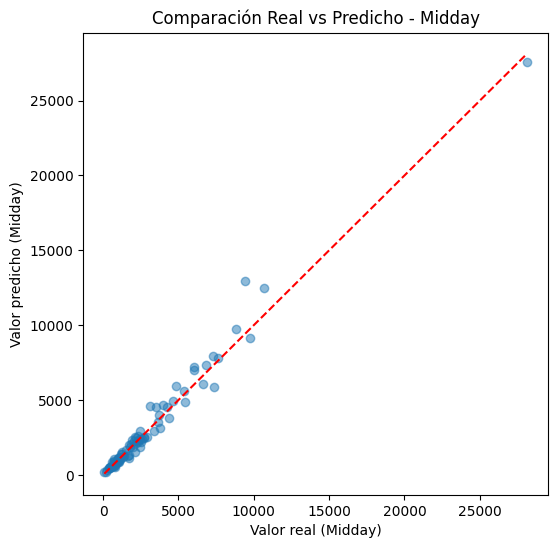

In [ ]:
# 2. Gráfico: reales vs predichos

# Para no saturar, mostramos solo una franja horaria (ejemplo: Midday)
real = Y_test["Midday"].values
pred = Y_pred[:, 2]   # columna 2 = Midday

plt.figure(figsize=(6,6))
plt.scatter(real, pred, alpha=0.5)
plt.plot([real.min(), real.max()], [real.min(), real.max()], 'r--')  # línea perfecta
plt.xlabel("Valor real (Midday)")
plt.ylabel("Valor predicho (Midday)")
plt.title("Comparación Real vs Predicho - Midday")
plt.show()

En la línea discontinua de refencia vemos que cada punto representa una estación, los puntos que caen sobre la línea es una predicción perfecta, por encima, el modelo sobreestima el nº de pasajeros y por debajo, los subestima.

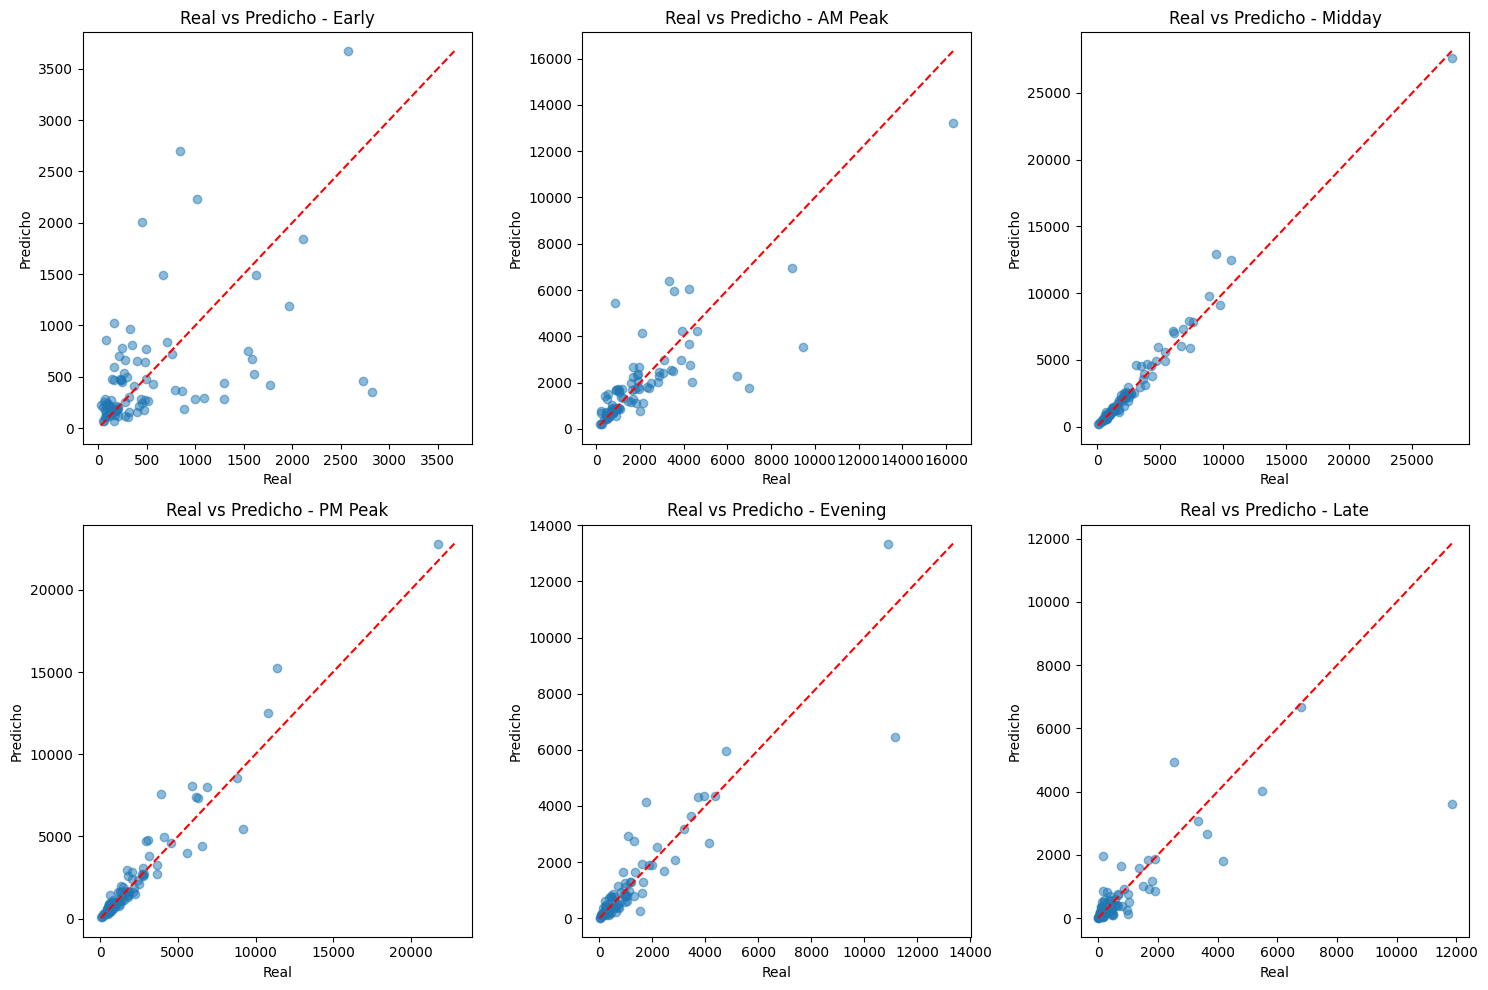

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lista de franjas horarias en el mismo orden que Y
franjas = ["Early", "AM Peak", "Midday", "PM Peak", "Evening", "Late"]

# Crear subplots (2 filas x 3 columnas = 6 franjas)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()  # aplana el array 2D en lista

for i, franja in enumerate(franjas):
    real = Y_test[franja].values
    pred = Y_pred[:, i]

    # Scatter real vs predicho
    axes[i].scatter(real, pred, alpha=0.5)

    # Línea perfecta (y = x)
    min_val = min(real.min(), pred.min())
    max_val = max(real.max(), pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')

    axes[i].set_title(f"Real vs Predicho - {franja}")
    axes[i].set_xlabel("Real")
    axes[i].set_ylabel("Predicho")

plt.tight_layout()
plt.show()

In [ ]:
En el conjunto de diagramas de dispersión para cada zona horaria se pueden sacar las siguentes conclusiones:

1. El modelo predice mejor en las franjas horarias en las que hay mas afluencia de pasajeros, como AM y middey.
2. El modelo predice peor en las franjas horarias donde la afluencia es muy pequeña, como en Early. La dispersión es grande.
3. En las estaciones con muchos pasajeros el ajuste es mejor y en las estaciones pequeñas el erros es mayor.

Por último, vamos a mostrar el MAPE por franja horaria, para saber con  precisión, donde falla mas el modelo.

In [16]:
# Calcular MAPE por franja
franjas = ["Early", "AM Peak", "Midday", "PM Peak", "Evening", "Late"]

for i, franja in enumerate(franjas):
    real = Y_test[franja].values
    pred = Y_pred[:, i]
    mape_franja = mean_absolute_percentage_error(real, pred)
    print(f"MAPE en {franja}: {mape_franja:.2f}%")

MAPE en Early: 108.35%
MAPE en AM Peak: 44.56%
MAPE en Midday: 14.78%
MAPE en PM Peak: 27.68%
MAPE en Evening: 40.04%
MAPE en Late: 83.60%
